In [1]:
%matplotlib inline
import sys
import pandas as pd
import tushare as ts
import os
import glob
import copy
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pymysql
from matplotlib.collections import LineCollection
from sklearn import cluster, covariance, manifold
from struct import *
from pandas.tseries.offsets import DateOffset,Day
from sqlalchemy import create_engine
print(__doc__)

Automatically created module for IPython interactive environment


### 连接tushare，找到所有股票、代码、行业信息和上市时间

In [2]:
'''
#打开数据库
HOSTNAME = "127.0.0.1"
PORT = "3306"
DATABASE = "TDX"
USERNAME = "root"
PASSWORD = "123"

DB_URI = "mysql+pymysql://{username}:{password}@{host}:{port}/{db}?charset=utf8".\
    format(username=USERNAME,password=PASSWORD,host=HOSTNAME,port=PORT,db=DATABASE)
engine = create_engine(DB_URI)
con = engine.connect()#创建连接
#engine.dispose() #关闭连接
#连接tushare
pro = ts.pro_api('31e6c92e6133d112d8ee557bb245044fde5daab04104598620f23921')
#获得交易日信息
jiaoyiri = pro.trade_cal(exchange='', start_date='20150901', end_date='20200709', fields='exchange,cal_date,is_open,pretrade_date', is_open='0')

#所有上市公司的基础信息，包含代码，上市交易所，公司名称，行业和上市日期
stock_basic = pro.stock_basic(exchange='', list_status='L', fields='ts_code,symbol,name,area,industry,list_date')
stock_basic.to_sql(name='stock_basic', con=con, if_exists='append', index=True)#插入索引用TRUE，不插入用FALSE
'''

'\n#打开数据库\nHOSTNAME = "127.0.0.1"\nPORT = "3306"\nDATABASE = "TDX"\nUSERNAME = "root"\nPASSWORD = "123"\n\nDB_URI = "mysql+pymysql://{username}:{password}@{host}:{port}/{db}?charset=utf8".    format(username=USERNAME,password=PASSWORD,host=HOSTNAME,port=PORT,db=DATABASE)\nengine = create_engine(DB_URI)\ncon = engine.connect()#创建连接\n#engine.dispose() #关闭连接\n#连接tushare\npro = ts.pro_api(\'31e6c92e6133d112d8ee557bb245044fde5daab04104598620f23921\')\n#获得交易日信息\njiaoyiri = pro.trade_cal(exchange=\'\', start_date=\'20150901\', end_date=\'20200709\', fields=\'exchange,cal_date,is_open,pretrade_date\', is_open=\'0\')\n\n#所有上市公司的基础信息，包含代码，上市交易所，公司名称，行业和上市日期\nstock_basic = pro.stock_basic(exchange=\'\', list_status=\'L\', fields=\'ts_code,symbol,name,area,industry,list_date\')\nstock_basic.to_sql(name=\'stock_basic\', con=con, if_exists=\'append\', index=True)#插入索引用TRUE，不插入用FALSE\n'

### 使用pymysql读取MYSQL中的数据

In [3]:
'''
import pymysql

host = 'localhost' # 数据库的ip地址
user = 'root'  # 数据库的账号
password = '123'  # 数据库的密码
port = 3306 # mysql数据库通用端口号
db='TDX',
charset='utf8'

mysql = pymysql.connect (host=host, user=user, password=password, port=port)
cursor = mysql.cursor()

#3编写sql
sql =  'select * from TDX.stock_basic where symbol = "600352"'
#4.执行sql
cursor.execute(sql)
#5.查看结果
# result = cursor.fetchone() #用于返回单条数据
results = cursor.fetchall() #用于返回多条数据
print(results)
#6.关闭查询
cursor.close()
#关闭数据库
mysql.close()
'''

'\nimport pymysql\n\nhost = \'localhost\' # 数据库的ip地址\nuser = \'root\'  # 数据库的账号\npassword = \'123\'  # 数据库的密码\nport = 3306 # mysql数据库通用端口号\ndb=\'TDX\',\ncharset=\'utf8\'\n\nmysql = pymysql.connect (host=host, user=user, password=password, port=port)\ncursor = mysql.cursor()\n\n#3编写sql\nsql =  \'select * from TDX.stock_basic where symbol = "600352"\'\n#4.执行sql\ncursor.execute(sql)\n#5.查看结果\n# result = cursor.fetchone() #用于返回单条数据\nresults = cursor.fetchall() #用于返回多条数据\nprint(results)\n#6.关闭查询\ncursor.close()\n#关闭数据库\nmysql.close()\n'

### 根据沪深300的代码从通达信的程序的安装目录中找原始文件，并解码为python数据，提取close值

In [4]:
#t通达信代码解析函数，并存入mysql中
def jiexiTDX_daily ( j_add='D:/Program Files (x86)/tdx/vipdoc/sh/lday/',code= 'code', sdate='2019-7-1'):
    os.chdir(j_add)
    #sh_list = glob.glob('*.day')
    address = os.getcwd()#返回当前目录
    dayfile = open(code, 'rb')
    buffer = dayfile.read()
    dayfile.close()
    #读取的数据长度
    buflengh = len(buffer) #32的整数倍
    #除32获利文件中存储了多少天的信息
    datenum = int(buflengh / 32)
    #解析每一天的数据的内容,每一天列表的起始位置和终止位置
    list_begin = 0
    list_end = 32
    #创建pandas股票数据表
    #将个股数据转换为pandas的dataFrame格式数据
    dl =[]
    for K in range(datenum):
        #解析32个字节一天数据
        a = unpack('IIIIIfII', buffer[list_begin:list_end])
        date  = pd.to_datetime(str(a[0]))
        open1 = a[1] / 100.0
        high  = a[2] / 100.0
        low   = a[3] / 100.0
        close = a[4] / 100.0
        amount = a[5] / 10.0
        vol = a[6]
        unused = a[7]
        dl.append([date,open1,high,low,close,amount,vol])
        #加32指向下一天的数据列表
        list_begin = list_begin + 32
        list_end = list_end + 32

    df = pd.DataFrame(dl, columns=['date','open','high','low','close','amount','vol'])
    df = df[df.date>sdate] #从输入的起始时间开始截取数据，截止到今天
    df.set_index("date",inplace=True)
    
    #清洗数据，把停盘的日期价格按前一个交易日复制，成交量写为0
    start = df.iloc[0:1].index.tolist()[0]#起始日期
    end = df.iloc[-1: ].index.tolist()[0]#结束日期
    idx = pd.bdate_range(start=start, end=end)#bdate_range，计算工作日的日期统计表
    #根据日期列表idx，用上一个交易日的值补齐停盘的价格，成交额按0计算
    data_t = df.reindex(idx)
    zvalues = data_t.loc[~(data_t.vol> 0)].loc[:, ['amount','volume']]
    data_t.update(zvalues.fillna(0))
    data_t.fillna(method='ffill', inplace=True) #前一天的值填充
    
    return data_t
#df.to_csv(save_add + os.sep + files_name +' .csv', encoding='utf-8')
#print (files_name + 'has been saved in'+ save_add +'!' )

In [5]:
#读取通达信软件下的日线数据，并转换为CSV格式，存入'D:/data'
def get_daily_data(symbols):
    #读取沪深300的股票列表，生成字典
    quote_tem = []
    
    if (symbols[0] == '0' or symbols[0] == '3'):  #深市股票,在深市文件中找     
        sz_add='D:/Program Files (x86)/tdx/vipdoc/sz/lday/'
        os.chdir(sz_add)
        sz_list = glob.glob('*.day')
        for i in range(len(sz_list)):
            if (sz_list[i][2:8] == symbols):
                tmp = jiexiTDX_daily(j_add='D:/Program Files (x86)/tdx/vipdoc/sz/lday/',code= sz_list[i])
                if len(quote_tem) == 0:
                    quote_tem = tmp
                else:
                    quote_tem.append(tmp)
                
                break;
            else:
                continue; 
                #break;
    elif(symbols[0] == '6'):
        sh_add='D:/Program Files (x86)/tdx/vipdoc/sh/lday/'
        os.chdir(sh_add)
        sh_list = glob.glob('*.day')
        address = os.getcwd()#返回当前目录
        for i in range(len(sh_list)):
            if (sh_list[i][2:8] == symbols):
                tmp = jiexiTDX_daily(j_add='D:/Program Files (x86)/tdx/vipdoc/sh/lday/',code = sh_list[i])
                if len(quote_tem) == 0:
                    quote_tem = temp
                else:
                    quote_tem.append(tmp)
                
                break;
            else:
                continue; 
    else:
        print('股票代码不正确！')
        #continue; 
    
    return quote_tem

# 主函数

In [6]:
if __name__ == "__main__":
    #定义全局变量
    hs300 = pd.read_csv('D:/data/hs302.csv', sep=',',encoding='utf-8')
    hs300.drop(columns='Unnamed: 0',inplace=True)
    hs300['股票'] =  hs300['股票'].astype(str).str.zfill(6)
    symbol_dict = dict(zip(hs300.股票,hs300.股票名称))
    symbols, names = np.array(sorted(symbol_dict.items())).T
    
    quotes = []  #全局变量
    
    for symbol in symbols:
        #print('Fetching quote history for %r' % symbol, file=sys.stderr)
        temp = get_daily_data(symbol)
        quotes.append(temp)

D:\Users\a\Anaconda3\lib\site-packages\pandas\core\indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [8]:
close_prices = np.vstack([q['close'] for q in quotes])
#open_prices = np.vstack([q['open'] for q in quotes])

In [9]:
close_change = close_prices[0][1:]-close_prices[0][0:-1]

In [13]:
# The daily variations of the quotes are what carry most information
variation = np.delete(close_prices,0, axis=1)
close_prices = np.delete(close_prices, -1, axis=1)

In [14]:
change = variation/close_prices                                  #修改为每日涨跌幅对比

In [15]:
# #############################################################################
# Learn a graphical structure from the correlations
#edge_model =  covariance.GraphLassoCV()
edge_model = covariance.MinCovDet()
# standardize the time series: using correlations rather than covariance
# is more efficient for structure recovery
X = change.copy().T
X /= X.std(axis=0)
edge_model.fit(X)

# #############################################################################
# Cluster using affinity propagation

D:\Users\a\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:622: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "


MinCovDet(assume_centered=False, random_state=None, store_precision=True,
     support_fraction=None)

In [16]:
#hs300.to_csv('D:/data/hs302.csv', encoding='utf-8')
symbol_dict = dict(zip(hs300.股票,hs300.股票名称))
symbols,names = np.array(sorted(symbol_dict.items())).T

In [18]:
_, labels = cluster.affinity_propagation(edge_model.covariance_)

n_labels = labels.max()

In [20]:
for i in range(n_labels+1):
    print('Cluster %i: %s' % ((i+1), ', '.join(names[labels == i])))

Cluster 1: 平安银行, 美的集团, 潍柴动力, 格力电器, 分众传媒, 苏泊尔, 宁波银行, 老板电器, 中公教育, 万达电影, 汇川技术, 宋城演艺
Cluster 2: 中联重科, 徐工机械, 长安汽车, 恒逸石化, 北新建材, 金螳螂, 东方雨虹
Cluster 3: 万科A, 华侨城A, 铜陵有色, 金科股份, 阳光城, 河钢股份, 鞍钢股份, 中南建设, 招商蛇口, 荣盛发展
Cluster 4: TCL科技, 东旭光电, 京东方A, 中航飞机
Cluster 5: 申万宏源, 渤海租赁, 天茂集团, 美锦能源, 国元证券, 广发证券, 传化智联, 西部证券, 国信证券, 青农商行, 东方财富
Cluster 6: 泸州老窖, 古井贡酒, 五粮液, 洋河股份, 海大集团
Cluster 7: 东阿阿胶, 云南白药, 双汇发展, 华东医药, 新和成, 美年健康, 信立泰, 延安必康
Cluster 8: 韵达股份, 申通快递
Cluster 9: 中兴通讯, 紫光股份, 大族激光, 苏宁易购, 石基信息, 金风科技, 科大讯飞, 大华股份, 海康威视, 比亚迪, 龙蟒佰利, 机器人, 同花顺, 碧水源
Cluster 10: 攀钢钒钛, 三花智控, 广联达, 赣锋锂业, 天齐锂业
Cluster 11: 荣盛石化
Cluster 12: 三七互娱, 巨人网络, 世纪华通, 完美世界, 芒果超媒
Cluster 13: 长江证券, 长城证券, 华林证券
Cluster 14: 长春高新, 华兰生物, 上海莱士, 科伦药业, 康弘药业, 乐普医疗, 爱尔眼科, 智飞生物, 沃森生物, 泰格医药
Cluster 15: 中航光电, 歌尔股份, 顺丰控股, 欧菲光, 立讯精密, 视源股份, 深南电路, 鹏鼎控股, 网宿科技, 信维通信, 三环集团, 蓝思科技
Cluster 16: 新希望, 牧原股份, 温氏股份, 浦发银行, 白云机场, 上海机场, 包钢股份, XD华能国, 华夏银行, 民生银行, 上港集团, 宝钢股份, 浙能电力, 华能水电, 华电国际, 中国石化, 南方航空, 中信证券, 三一重工, 招商银行, 中直股份, 保利地产, 中国联通, 国投资本, 宇通客车, 葛洲坝, 同仁堂, XD特变电, 同方股份, 上汽集团, 国金证券, 北方稀土,

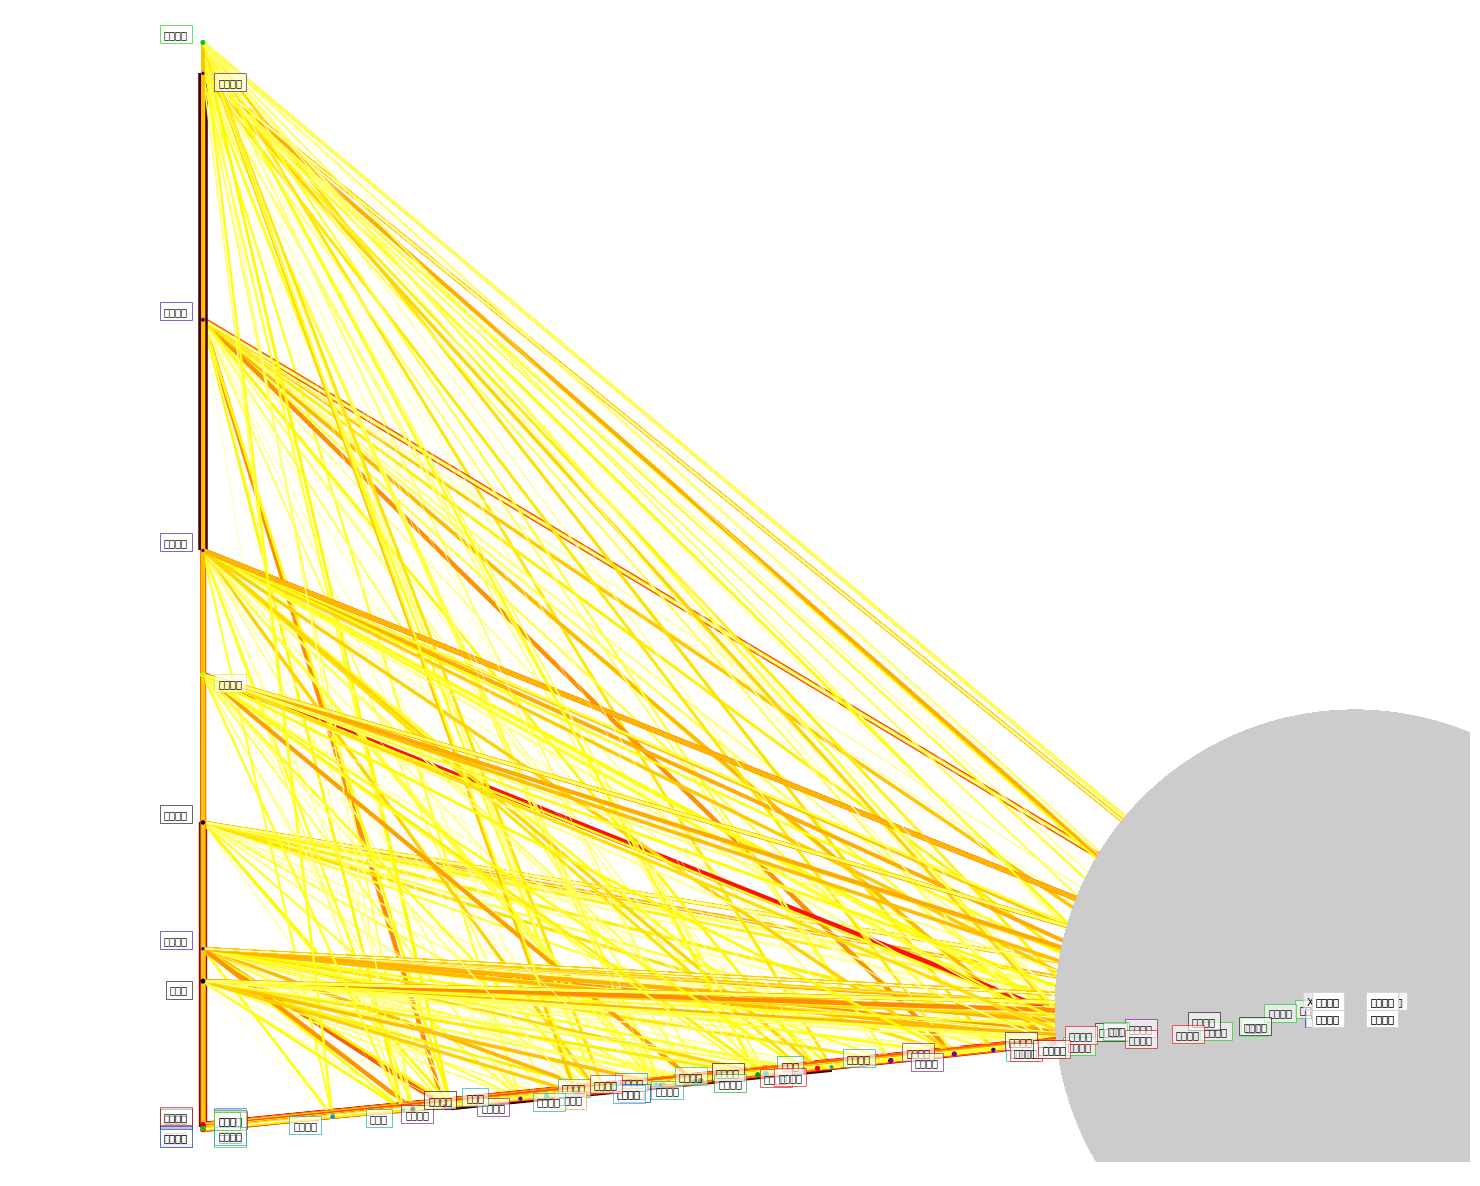

In [21]:
# #############################################################################
# Find a low-dimension embedding for visualization: find the best position of
# the nodes (the stocks) on a 2D plane

# We use a dense eigen_solver to achieve reproducibility (arpack is
# initiated with random vectors that we don't control). In addition, we
# use a large number of neighbors to capture the large-scale structure.
node_position_model = manifold.LocallyLinearEmbedding(
    n_components=2, eigen_solver='dense', n_neighbors=6)

embedding = node_position_model.fit_transform(X.T).T

# #############################################################################
# Visualization
plt.figure(1, facecolor='w', figsize=(20, 16))
plt.clf()
ax = plt.axes([0., 0., 1., 1.])
plt.axis('off')

# Display a graph of the partial correlations
partial_correlations = edge_model.precision_.copy()
d = 1 / np.sqrt(np.diag(partial_correlations))
partial_correlations *= d
partial_correlations *= d[:, np.newaxis]
non_zero = (np.abs(np.triu(partial_correlations, k=1)) > 0.02)

# Plot the nodes using the coordinates of our embedding
plt.scatter(embedding[0], embedding[1], s=100 * d ** 2, c=labels,
            cmap=plt.cm.nipy_spectral)

# Plot the edges
start_idx, end_idx = np.where(non_zero)
# a sequence of (*line0*, *line1*, *line2*), where::
#            linen = (x0, y0), (x1, y1), ... (xm, ym)
segments = [[embedding[:, start], embedding[:, stop]]
            for start, stop in zip(start_idx, end_idx)]
values = np.abs(partial_correlations[non_zero])
lc = LineCollection(segments,
                    zorder=0, cmap=plt.cm.hot_r,
                    norm=plt.Normalize(0, .7 * values.max()))
lc.set_array(values)
lc.set_linewidths(15 * values)
ax.add_collection(lc)

# Add a label to each node. The challenge here is that we want to
# position the labels to avoid overlap with other labels
for index, (name, label, (x, y)) in enumerate(
        zip(names, labels, embedding.T)):

    dx = x - embedding[0]
    dx[index] = 1
    dy = y - embedding[1]
    dy[index] = 1
    this_dx = dx[np.argmin(np.abs(dy))]
    this_dy = dy[np.argmin(np.abs(dx))]
    if this_dx > 0:
        horizontalalignment = 'left'
        x = x + .002
    else:
        horizontalalignment = 'right'
        x = x - .002
    if this_dy > 0:
        verticalalignment = 'bottom'
        y = y + .002
    else:
        verticalalignment = 'top'
        y = y - .002
    plt.text(x, y, name, size=10,
             horizontalalignment=horizontalalignment,
             verticalalignment=verticalalignment,
             bbox=dict(facecolor='w',
                       edgecolor=plt.cm.nipy_spectral(label / float(n_labels)),
                       alpha=.6))

plt.xlim(embedding[0].min() - .15 * embedding[0].ptp(),
         embedding[0].max() + .10 * embedding[0].ptp(),)
plt.ylim(embedding[1].min() - .03 * embedding[1].ptp(),
         embedding[1].max() + .03 * embedding[1].ptp())

plt.show()